In [1]:
import math
from neuroml import NeuroMLDocument
from neuroml import Cell
from neuroml import BiophysicalProperties
from neuroml import MembraneProperties, Q10ConductanceScaling
from neuroml import IncludeType
from neuroml import ChannelDensity, ChannelDensityNernst, ChannelDensityNernstCa2, ChannelDensityGHK, ChannelDensityGHK2
from neuroml import SpikeThresh
from neuroml import SpecificCapacitance
from neuroml import InitMembPotential
from neuroml import IntracellularProperties
from neuroml import Resistivity, Species
from neuroml import Morphology, Segment, Point3DWithDiam
from neuroml import Network, Population
from neuroml import PulseGenerator, ExplicitInput
from pyneuroml import pynml
import numpy as np
from pyneuroml.lems import LEMSSimulation
import typing
import plotly.graph_objects as go
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [24]:
def generate_interactive_plot(
    xvalues: typing.List[float],
    yvalues: typing.List[float],
    title: str,
    labels: typing.Optional[typing.List[str]] = None,
    linestyles: typing.Optional[typing.List[str]] = None,
    linewidths: typing.Optional[
        typing.Union[typing.List[int], typing.List[float]]
    ] = None,
    markers: typing.Optional[typing.Union[typing.List[str], typing.List[int]]] = None,
    markersizes: typing.Optional[
        typing.Union[typing.List[float], typing.List[int]]
    ] = None,
    plot_bgcolor: typing.Optional[str] = None,
    modes: typing.Optional[typing.List[str]] = None,
    xaxis: str = None,
    yaxis: str = None,
    legend_title: str = None,
    xaxis_color: str = "#fff",
    yaxis_color: str = "#fff",
    xaxis_width: typing.Union[float, int] = 1,
    yaxis_width: typing.Union[float, int] = 1,
    xaxis_mirror: typing.Union[str, bool] = False,
    yaxis_mirror: typing.Union[str, bool] = False,
    xaxis_spikelines: bool = False,
    yaxis_spikelines: bool = False,
    grid: bool = True,
    logx: bool = False,
    logy: bool = False,
    layout: typing.Optional[dict] = None,
    show_interactive: bool = True,
    save_figure_to: typing.Optional[str] = None,
) -> None:
    """Utility function to generate interactive plots using Plotly.
    This function can be used to generate graphs with multiple plot lines.
    For example, to plot two metrics you can use:
    ::
        generate_interactive_plot(xvalues=[[ax1, ax2, ax3], [bx1, bx2, bx3]], yvalues=[[ay1, ay2, ay3], [by1, by2, by3]], labels=["metric 1", "metric 2"])
    Please note that while plotting multiple plots, you should take care to
    ensure that the number of x values and y values for each metric correspond.
    These lists are passed directly to Plotly for plotting without additional
    sanity checks.
    A number of options are provided for convenience to allow plotting of
    multiple traces in the same plot and modification of common layout options.
    A layout dict can also be passed instead, which will overwrite any
    individually set options. If you need more customisation, please look at
    the source code of this method to write your own.
    See the plotly documentation for more information:
    https://plotly.com/python-api-reference/generated/plotly.graph_objects.scatter.html
    :param xvalues: X values
    :type xvalues: list of lists
    :param yvalues: Y values
    :type yvalues: lists of lists
    :param title: title of plot
    :type title: str
    :param labels: labels for each plot (default: None)
    :type labels: list of strings
    :param modes: modes of individual plots: "markers", "lines",
        "lines+markers": default "lines+markers"
    :type modes: str
    :param linestyles: list of line styles (default: None)
    :type linestyles: list strings
    :param linewidths: list of line widths (default: None)
    :type linewidths: list of floats/int
    :param markers: list of markers (default: None)
    :type markers: list of plotly marker values. See:
        https://plotly.com/python-api-reference/generated/plotly.graph_objects.scatter.html#plotly.graph_objects.scatter.Marker.symbol
    :param markersizes: list of marker sizes (default: None)
    :type markersizes: list of ints/floats
    :param plot_bgcolor: background color of plotting area b/w axes
        See https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html#plotly.graph_objects.Figure
    :type plot_bgcolor: str
    :param xaxis: label of X axis (default: None)
    :type xaxis: str
    :param yaxis: label of Y axis (default: None)
    :type yaxis: str
    :param legend_title: title of legend
    :type legend_title: str
    :param xaxis_color: color of xaxis
    :type xaxis_color: str
    :param yaxis_color: color of yaxis
    :type yaxis_color: str
    :param xaxis_width: width of xaxis
    :type xaxis_width: int/float
    :param yaxis_width: width of yaxis
    :type yaxis_width: int/float
    :param xaxis_mirror: xaxis mirror options:
        https://plotly.com/python/reference/layout/xaxis/#layout-xaxis-mirror
    :type xaxis_mirror: bool/str
    :param yaxis_mirror: yaxis mirror options
        https://plotly.com/python/reference/layout/xaxis/#layout-xaxis-mirror
    :type yaxis_mirror: bool/str
    :param xaxis_spikelines: toggle spike lines on x axis
        https://plotly.com/python/hover-text-and-formatting/#spike-lines
    :type xaxis_spikelines: bool/str
    :param yaxis_spikelines: toggle spike lines on x axis
        https://plotly.com/python/hover-text-and-formatting/#spike-lines
    :type yaxis_spikelines: bool/str
    :param grid: enable/disable grid (default: True)
    :type grid: boolean
    :param logx: should the x axis be in log scale (default: False)
    :type logx: boolean
    :param logy: should the y ayis be in log scale (default: False)
    :type logy: boolean
    :param layout: plot layout properties: these will overwrite all other
        layout options specified
        See:
        https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html#plotly.graph_objects.Figure.update_layout
    :type layout: dict
    :param show_interactive: toggle whether interactive plot should be opened (default: True)
    :type show_interactive: bool
    :param save_figure_to: location to save generated figure to (default: None)
        Requires the kaleido package to be installed.
        See for supported formats:
        https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html#plotly.graph_objects.Figure.write_image
        Note: you can also save the file from the interactive web page.
    :type save_figure_to: str
    """
    fig = go.Figure()

    if len(xvalues) != len(yvalues):
        raise ValueError("length of x values does not match length of y values")

    if not labels or len(labels) != len(xvalues):
        raise ValueError("labels not provided correctly")

    if not markersizes:
        markersizes = len(xvalues) * [6.0]
    if not markers:
        markers = len(xvalues) * [0]
    if not linestyles:
        linestyles = len(xvalues) * ["solid"]
    if not linewidths:
        linewidths = len(xvalues) * [2.0]
    if not modes:
        modes = len(xvalues) * ["lines+markers"]

    for i in range(len(xvalues)):
        fig.add_trace(
            go.Scatter(
                x=xvalues[i],
                y=yvalues[i],
                name=labels[i],
                marker={"size": markersizes[i], "symbol": markers[i]},
                line={"dash": linestyles[i], "width": linewidths[i]},
                mode=modes[i],
            ),
        )

    fig.update_layout(
        title={"text": title, "xanchor": "auto"},
        xaxis_title=xaxis,
        yaxis_title=yaxis,
        legend_title=legend_title,
        plot_bgcolor=plot_bgcolor,
        hovermode="closest",
    )

    if logx:
        fig.update_xaxes(type="log")
    else:
        fig.update_xaxes(type="linear")
    if logy:
        fig.update_yaxes(type="log")
    else:
        fig.update_yaxes(type="linear")
    fig.update_xaxes(
        showgrid=grid,
        linecolor=xaxis_color,
        linewidth=xaxis_width,
        mirror=xaxis_mirror,
        showspikes=xaxis_spikelines,
    )
    fig.update_yaxes(
        showgrid=grid,
        linecolor=yaxis_color,
        linewidth=yaxis_width,
        mirror=yaxis_mirror,
        showspikes=yaxis_spikelines,
    )

    if layout:
        fig.update_layout(layout, overwrite=True)

    if show_interactive:
        fig.show()

    if save_figure_to:
        logger.info(
            "Saving image to %s of plot: %s" % (os.path.abspath(save_figure_to), title)
        )
        fig.write_image(save_figure_to, scale=2, width=1024, height=768)
        logger.info("Saved image to %s of plot: %s" % (save_figure_to, title))

In [2]:
def main():
    """Main function

    Include the NeuroML model into a LEMS simulation file, run it, plot some
    data.
    """
    # Simulation bits

    sim_id = "pyr_single_comp_ca"
    simulation = LEMSSimulation(sim_id=sim_id, duration=700, dt=0.005, simulation_seed=123)

    # Include the NeuroML model file
    simulation.include_neuroml2_file(create_network())
    # Assign target for the simulation
    simulation.assign_simulation_target("single_pyr_cell_network")

    # Recording information from the simulation
    simulation.create_output_file(id="output0", file_name=sim_id + ".dat")
    simulation.add_column_to_output_file("output0", column_id="pop0[0]_v", quantity="pop0[0]/v")

    simulation.create_output_file(id="cai", file_name=sim_id + ".cai.dat")
    simulation.add_column_to_output_file("cai", column_id="pop0[0]_cai", quantity="pop0[0]/caConc")

    simulation.create_output_file(id="ica", file_name=sim_id + ".ica.dat")
    simulation.add_column_to_output_file("ica", column_id="pop0[0]_ica", quantity="pop0[0]/iCa")

    # simulation.create_output_file(id="eca", file_name=sim_id + ".eca.dat")
    # simulation.add_column_to_output_file("eca", column_id="pop0[0]_ica", quantity="pop0[0]/iCa")

    simulation.create_output_file(id="sca_eca", file_name=sim_id + ".sca_eca.dat")
    simulation.add_column_to_output_file("sca_eca", column_id="pop0[0]_sca_eca", quantity="pop0[0]/pyr_b_prop/membraneProperties/soma_sca/erev")

    # Recording information from the simulation
    simulation.create_output_file(id="sca_m", file_name=sim_id + ".sca_m.dat")
    simulation.add_column_to_output_file("sca_m", column_id="pop0[0]_sca_m", quantity="pop0[0]/pyr_b_prop/membraneProperties/soma_sca/sca/m/q")

    simulation.create_output_file(id="sca_h", file_name=sim_id + ".sca_h.dat")
    simulation.add_column_to_output_file("sca_h", column_id="pop0[0]_sca_h", quantity="pop0[0]/pyr_b_prop/membraneProperties/soma_sca/sca/h/q")

    simulation.create_output_file(id="kca_n", file_name=sim_id + ".kca_n.dat")
    simulation.add_column_to_output_file("kca_n", column_id="pop0[0]_kca_n", quantity="pop0[0]/pyr_b_prop/membraneProperties/soma_kca/kca/n/q")

    # Save LEMS simulation to file
    sim_file = simulation.save_to_file()

    # Run the simulation using the default jNeuroML simulator
    pynml.run_lems_with_jneuroml(sim_file, max_memory="2G", nogui=True, plot=False)
    # Plot the data
    plot_data(sim_id)

In [3]:
def plot_data(sim_id):
    """Plot the sim data.

    Load the data from the file and plot the graph for the membrane potential
    using the pynml generate_plot utility function.

    :sim_id: ID of simulaton

    """
    data_array = np.loadtxt(sim_id + ".dat")
    pynml.generate_plot([data_array[:, 0]], [data_array[:, 1]], "Membrane potential", show_plot_already=False, save_figure_to=sim_id + "-v.png", xaxis="time (s)", yaxis="membrane potential (V)")
    # generate_interactive_plot(xvalues=[data_array[:, 0]],
    #                     yvalues=[data_array[:, 1]],
    #                     labels=["Vm"],
    #                     title="Membrane Potential plot",
    #                     show_interactive=True, xaxis="time (s)", yaxis="Vm")

    data_array_sca_m = np.loadtxt(sim_id + ".sca_m.dat")
    pynml.generate_plot([data_array_sca_m[:, 0]], [data_array_sca_m[:, 1]], "sca m gate", show_plot_already=False, save_figure_to=sim_id + "-sca_m.png", xaxis="time (s)", yaxis="q (sca m gate)")
    # generate_interactive_plot(xvalues=[data_array_sca_m[:, 0]],
    #                     yvalues=[data_array_sca_m[:, 1]],
    #                     labels=["sca_m"],
    #                     title="sca m gate plot",
    #                     show_interactive=True, xaxis="time (s)", yaxis="q (sca-m)")

    data_array_sca_h = np.loadtxt(sim_id + ".sca_h.dat")
    pynml.generate_plot([data_array_sca_h[:, 0]], [data_array_sca_h[:, 1]], "sca h gate", show_plot_already=False, save_figure_to=sim_id + "-sca_h.png", xaxis="time (s)", yaxis="q (sca h gate)")
    # generate_interactive_plot(xvalues=[data_array_sca_h[:, 0]],
    #                     yvalues=[data_array_sca_h[:, 1]],
    #                     labels=["sca_h"],
    #                     title="sca h gate plot",
    #                     show_interactive=True, xaxis="time (s)", yaxis="q (sca-h)")

    data_array_kca_n = np.loadtxt(sim_id + ".kca_n.dat")
    pynml.generate_plot([data_array_kca_n[:, 0]], [data_array_kca_n[:, 1]], "kca n gate", show_plot_already=False, save_figure_to=sim_id + "-kca_n.png", xaxis="time (s)", yaxis="q (kca n gate)")
    # generate_interactive_plot(xvalues=[data_array_kca_n[:, 0]],
    #                         yvalues=[data_array_kca_n[:, 1]],
    #                         labels=["kca_n"],
    #                         title="kca n gate plot",
    #                         show_interactive=True, xaxis="time (s)", yaxis="q (kca-n)")

    # data_array_eca = np.loadtxt(sim_id + ".sca_eca.dat")
    # pynml.generate_plot([data_array_eca[:, 0]], [data_array_eca[:, 1]], "eca", show_plot_already=False, save_figure_to=sim_id + "-eca.png", xaxis="time (s)", yaxis="eca")


    data_array_ca = np.loadtxt(sim_id + ".cai.dat")
    pynml.generate_plot([data_array_ca[:, 0]], [data_array_ca[:, 1]], "caConc", show_plot_already=False, save_figure_to=sim_id + "-caConc.png", xaxis="time (s)", yaxis="caConc")
    # generate_interactive_plot(xvalues=[data_array_ca[:, 0]],
    #                         yvalues=[data_array_ca[:, 1]],
    #                         labels=["cai"],
    #                         title="cai plot",
    #                         show_interactive=True, xaxis="time (s)", yaxis="caConc")

    data_array_ica = np.loadtxt(sim_id + ".ica.dat")
    pynml.generate_plot([data_array_ica[:, 0]], [data_array_ica[:, 1]*-1], "iCa", show_plot_already=False, save_figure_to=sim_id + "-iCa.png", xaxis="time (s)", yaxis="iCa")
    # generate_interactive_plot(xvalues=[data_array_ica[:, 0]],
    #                     yvalues=[data_array_ica[:, 1]],
    #                     labels=["ica"],
    #                     title="ica plot",
    #                     show_interactive=True, xaxis="time (s)", yaxis="iCa")


In [4]:
def create_cell():
    pyr_cell_doc = NeuroMLDocument(id='cell', notes="Layer 5 Pyramidal cell")
    pyr_cell_fn = "pyr_soma_ca_cell.nml"
 
    pyr_cell_doc.includes.append(IncludeType("../pas.channel.nml"))
    # pyr_cell_doc.includes.append(IncludeType("nat.channel.nml"))
    pyr_cell_doc.includes.append(IncludeType("../cad.nml"))
    pyr_cell_doc.includes.append(IncludeType("../sca.channel.nml"))
    pyr_cell_doc.includes.append(IncludeType("../kca.channel.nml"))

    # Define a cell
    pyr_cell = Cell(id="pyr_cell", notes="A single compartment Layer 5 Pyramidal cell")

    # Define its biophysical properties
    bio_prop = BiophysicalProperties(id="pyr_b_prop")
    #  notes="Biophysical properties for Layer 5 Pyramidal cell")

    # Membrane properties are a type of biophysical properties
    mem_prop = MembraneProperties()
    # Add membrane properties to the biophysical properties
    bio_prop.membrane_properties = mem_prop

    # Append to cell
    pyr_cell.biophysical_properties = bio_prop

    # cond_scaling = Q10ConductanceScaling(q10_factor="2.3", experimental_temp="23 degC")

    pas_channel_density = ChannelDensity(id="pas_channels", cond_density="0.485726 S_per_m2", erev="-80.3987 mV", ion="non_specific", ion_channel="pas")
    mem_prop.channel_densities.append(pas_channel_density)

    # nat_channel_density = ChannelDensity(id="nat_channels", cond_density="236.616175 S_per_m2", erev="55 mV", ion="na", ion_channel="nat")
    # mem_prop.channel_densities.append(nat_channel_density)

    # sca_soma
    sca_channel_density = ChannelDensity(id="soma_sca", ion_channel="sca", cond_density="0.45423528 S_per_m2", ion="ca", erev="140mV")
    mem_prop.channel_densities.append(sca_channel_density)

    kca_channel_density = ChannelDensity(id="soma_kca", ion_channel="kca", cond_density="6.15058501 S_per_m2", ion="k", erev="-80mV")
    mem_prop.channel_densities.append(kca_channel_density)

    # Other membrane properties
    mem_prop.spike_threshes.append(SpikeThresh(value="-20mV"))
    mem_prop.specific_capacitances.append(SpecificCapacitance(value="2.23041 uF_per_cm2"))
    mem_prop.init_memb_potentials.append(InitMembPotential(value="-65mV"))

    intra_prop = IntracellularProperties()
    intra_prop.resistivities.append(Resistivity(value="0.082 kohm_cm"))

    intra_prop.species.append(Species(id="ca", concentration_model="cad", ion="ca", initial_concentration="1e-4 mM",
                             initial_ext_concentration="2 mM"))

    # Add to biological properties
    bio_prop.intracellular_properties = intra_prop

    # Morphology
    morph = Morphology(id="pyr_cell_morph")
    #  notes="Simple morphology for the HH cell")
    seg = Segment(id="0", name="soma", notes="Soma segment")
    # We want a diameter such that area is 1000 micro meter^2
    # surface area of a sphere is 4pi r^2 = 4pi diam^2
    # diam = math.sqrt(1682 / math.pi)
    proximal = Point3DWithDiam(x="0", y="0", z="0", diameter=str(23.1453))
    distal = Point3DWithDiam(x="0", y="23.1453", z="0", diameter=str(23.1453))
    seg.proximal = proximal
    seg.distal = distal
    morph.segments.append(seg)
    pyr_cell.morphology = morph

    pyr_cell_doc.cells.append(pyr_cell)
    pynml.write_neuroml2_file(nml2_doc=pyr_cell_doc, nml2_file_name=pyr_cell_fn, validate=True)
    return pyr_cell_fn

create_cell()

pyNeuroML >>> INFO - Executing: (java -Xmx400M  -jar  "/Users/shayan/opt/anaconda3/envs/neuron/lib/python3.10/site-packages/pyneuroml/lib/jNeuroML-0.12.0-jar-with-dependencies.jar" -validate "soma_pyr_ca_cell.nml" ) in directory: .
pyNeuroML >>> INFO - Command completed. Output: 
  jNeuroML >>   jNeuroML v0.12.0
  jNeuroML >>  Validating: /Users/shayan/Desktop/OSB/BahlEtAl2012_ReducedL5PyrCell/NeuroML2/test_ca/soma_pyr_ca_cell.nml
  jNeuroML >>  Valid against schema and all tests
  jNeuroML >>  No warnings
  jNeuroML >>  
  jNeuroML >>  Validated 1 files: All valid and no warnings
  jNeuroML >>  
  jNeuroML >>  


'soma_pyr_ca_cell.nml'

In [5]:
def create_network():
    """Create the network

    :returns: name of network nml file
    """
    net_doc = NeuroMLDocument(id="network",
                              notes="Pyramidal cell network")
    net_doc_fn = "pyr_soma_ca.net.nml"
    net_doc.includes.append(IncludeType(href=create_cell()))
    # Create a population: convenient to create many cells of the same type
    pop = Population(id="pop0", notes="A population for pyramidal cell", component="pyr_cell", size=1)
    # Input
    pulsegen = PulseGenerator(id="pg", notes="Simple pulse generator", delay="100ms", duration="500ms", amplitude="0.1nA")

    exp_input = ExplicitInput(target="pop0[0]", input="pg")

    net = Network(id="single_pyr_cell_network",
                  type="networkWithTemperature",
                  temperature = "37 degC",
                  note="A network with a single population")
    net_doc.pulse_generators.append(pulsegen)
    net.explicit_inputs.append(exp_input)
    net.populations.append(pop)
    net_doc.networks.append(net)

    pynml.write_neuroml2_file(nml2_doc=net_doc, nml2_file_name=net_doc_fn, validate=True)
    return net_doc_fn

pyNeuroML >>> INFO - Executing: (java -Xmx400M  -jar  "/Users/shayan/opt/anaconda3/envs/neuron/lib/python3.10/site-packages/pyneuroml/lib/jNeuroML-0.12.0-jar-with-dependencies.jar" -validate "soma_pyr_ca_cell.nml" ) in directory: .
pyNeuroML >>> INFO - Command completed. Output: 
  jNeuroML >>   jNeuroML v0.12.0
  jNeuroML >>  Validating: /Users/shayan/Desktop/OSB/BahlEtAl2012_ReducedL5PyrCell/NeuroML2/test_ca/soma_pyr_ca_cell.nml
  jNeuroML >>  Valid against schema and all tests
  jNeuroML >>  No warnings
  jNeuroML >>  
  jNeuroML >>  Validated 1 files: All valid and no warnings
  jNeuroML >>  
  jNeuroML >>  
pyNeuroML >>> INFO - Executing: (java -Xmx400M  -jar  "/Users/shayan/opt/anaconda3/envs/neuron/lib/python3.10/site-packages/pyneuroml/lib/jNeuroML-0.12.0-jar-with-dependencies.jar" -validate "soma_pyr_ca_net.nml" ) in directory: .
pyNeuroML >>> INFO - Command completed. Output: 
  jNeuroML >>   jNeuroML v0.12.0
  jNeuroML >>  Validating: /Users/shayan/Desktop/OSB/BahlEtAl2012_R

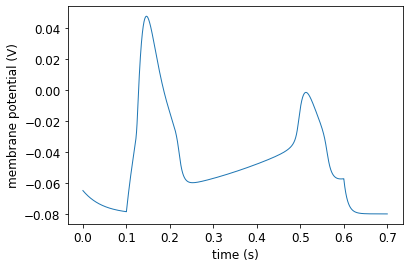

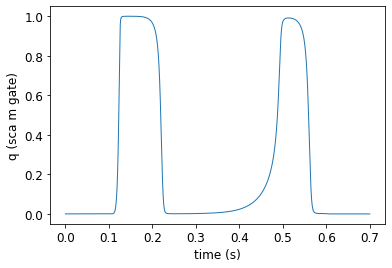

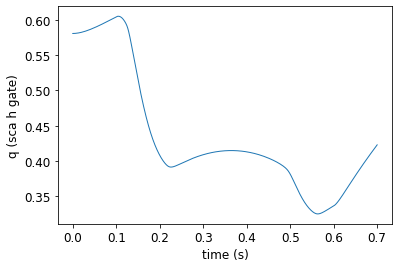

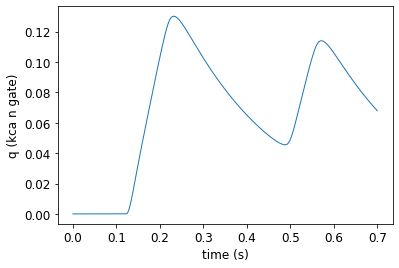

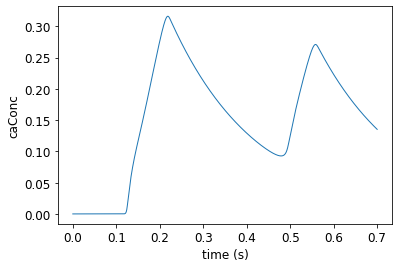

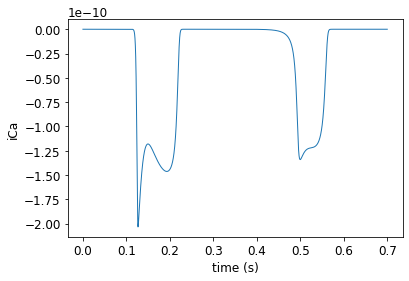

In [6]:
if __name__ == "__main__":
    main()